In [1]:
import sys,os,copy, pickle, glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
from smodels.experiment.databaseObj import Database
from smodels.share.models import SMparticles, mssm
from smodels.tools.physicsUnits import fb, TeV, pb, GeV
from smodels.tools import runtime
from smodels.theory.element import Element
from smodels.tools.simplifiedLikelihoods import Data, UpperLimitComputer
import matplotlib.pyplot as plt
import seaborn as sns
runtime._drmax = 0.338
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
sns.set_palette(sns.color_palette("deep"))

### Load database

In [2]:
db = Database('../official124_smodels200.pcl')

### Get efficiency maps for all SRs

In [3]:
#Get EM:
expEM = db.getExpResults(analysisIDs=['ATLAS-SUSY-2016-07'],dataTypes=['efficiencyMap'],txnames=['T2'])[0]

#### Get efficiencies for grid points

In [4]:
#Define grid points:
mSQ = np.arange(400.,1700.,50.)
mLSP = np.arange(0.,1200,25.)

#Get the efficiencies for each point for all datasets:
effs = []
for m0 in mSQ:
    for m1 in mLSP:
        if m1 > m0: continue
        mass = [[m0*GeV,m1*GeV]]*2
        effDict = {}
        for ds in expEM.datasets:
            eff = ds.txnameList[0].txnameData.getValueFor(mass)
            effDict[ds.dataInfo.dataId] = eff
        if all([(eff == None or eff == 0.0) for eff in effDict.values()]):
            continue
        effs.append([[m0,m1],effDict])

#### Compute upper limit  and expected upper limit for each SR for Nobs = Nbg

In [5]:
ulDict = {}
ulExpDict = {}
lumi = 36.1/fb
ntoys, alpha = 200000, .05
comp = UpperLimitComputer(ntoys, 1. - alpha)
for ds in expEM.datasets:
    Nbg = ds.dataInfo.expectedBG
    bgErr2 = ds.dataInfo.bgError**2
    Nobs = Nbg
    #Observed UL:
    dataModel = Data(Nobs, Nbg, bgErr2, None, 1. )
    ul = comp.ulSigma(dataModel, marginalize=False )/lumi.asNumber(1./fb)
    #Expected UL:
    dataModel = Data(Nbg, Nbg, bgErr2, None, 1. )
    ulExp = comp.ulSigma(dataModel, marginalize=False )/lumi.asNumber(1./fb)
    ulDict[ds.dataInfo.dataId] = ul
    ulExpDict[ds.dataInfo.dataId] = ulExp

#### Compute upper limit  and expected upper limit for each SR for Nobs = Nbg+Nsignal

In [6]:
#Mass of inject signal:
mInj = [[734.9*GeV,162.6*GeV]]*2
#cross-section of injected T2:
xsec = 23.95*fb
lumi = 36.1/fb
#Get efficiencies in each SR:
effInj = {}
for ds in expEM.datasets:
    eff = ds.txnameList[0].txnameData.getValueFor(mInj)
    effInj[ds.dataInfo.dataId] = eff
    
#Recompute upper limits:
ulDictInj = {}
for ds in expEM.datasets:
    eff = effInj[ds.dataInfo.dataId]
    Nbg = ds.dataInfo.expectedBG
    bgErr2 = ds.dataInfo.bgError**2
    Nsig = (xsec*eff*lumi).asNumber()
    Nobs = int(Nbg+Nsig)
    #New upper limit:
    dataModel = Data(Nobs, Nbg, bgErr2, None, 1. )
    ulNew = comp.ulSigma(dataModel, marginalize=False )/lumi.asNumber(1./fb)
    ulDictInj[ds.dataInfo.dataId] = ulNew

#### Compute UL map WITHOUT signal injection

In [7]:
xsecULs = []
for pt in effs:
    mass = pt[0]
    effDict = pt[1]
    uls = dict([[SR,ulDict[SR]/eff] for SR,eff in effDict.items() if eff])
    ulsExp = [[SR,ulExpDict[SR]/eff] for SR,eff in effDict.items() if eff]
    #Use the best expected SR to set the limit:
    bestSR = ulsExp[np.argmin([x[1] for x in ulsExp])][0]
    ul = uls[bestSR]
    ulExp = dict(ulsExp)[bestSR]
    xsecULs.append(mass+[ul,ulExp])
    
xsecULS = np.array(xsecULs)    

#### Compute UL map WITH signal injection

In [8]:
#Compute upper limits for each signal region (WITH injection):
xsecULsInj = []
for pt in effs:
    mass = pt[0]
    effDict = pt[1]
    uls = dict([[SR,ulDictInj[SR]/eff] for SR,eff in effDict.items() if eff])
    ulsExp = [[SR,ulExpDict[SR]/eff] for SR,eff in effDict.items() if eff]
    #Use the best expected SR to set the limit:
    bestSR = ulsExp[np.argmin([x[1] for x in ulsExp])][0]
    ul = uls[bestSR]
    ulExp = dict(ulsExp)[bestSR]
    xsecULsInj.append(mass+[ul,ulExp])
    
xsecULsInj = np.array(xsecULsInj)    

### Compare UL map with Nobs=Nbg vs Nobs = Nbg+Nsignal

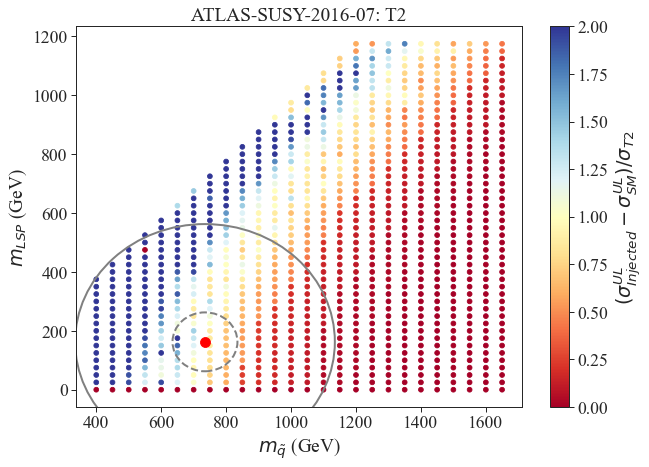

In [14]:
fig = plt.figure(figsize=(10,7))
plt.scatter(xsecULsInj[:,0],xsecULsInj[:,1],c=(xsecULsInj[:,2]-xsecULsInj[:,3])/xsec.asNumber(fb),
            cmap=plt.cm.get_cmap('RdYlBu'),  vmin=0.,vmax=2.0)
ax = plt.gca()
# plt.scatter(,c='red',s=20)
circle400 = plt.Circle((mInj[0][0].asNumber(GeV), mInj[0][1].asNumber(GeV)), 400, color='gray', 
                       fill=False,linewidth=2)
circle100 = plt.Circle((mInj[0][0].asNumber(GeV), mInj[0][1].asNumber(GeV)), 100, color='gray', 
                       fill=False, linestyle='--',linewidth=2)
ax.add_artist(circle400)
ax.add_artist(circle100)
plt.xlabel(r'$m_{\tilde q}$ (GeV)')
plt.ylabel(r'$m_{LSP}$ (GeV)')
plt.colorbar(label=r'$(\sigma^{UL}_{Injected} - \sigma^{UL}_{SM})/\sigma_{T2}$')
plt.title('ATLAS-SUSY-2016-07: T2')

plt.scatter(mInj[0][0].asNumber(GeV),mInj[0][1].asNumber(GeV),
            s=100,c='red',marker='o')


plt.show()